In [6]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                       

In [7]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


In [8]:
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    CLIENT_ID = 'T1LUMOHYFVR21KSZSVKTKIFO1DPONRPOL4PGKBLWSYTPNDNV' # your Foursquare ID
    CLIENT_SECRET = 'JBKZMRN5WS2PBXLZDUMMLCYJIDZELUNSSP3QKM51GSHXXWB0' # your Foursquare Secret
    VERSION = '20180604'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


In [9]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


In [10]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [11]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
ny_data.shape

(306, 4)

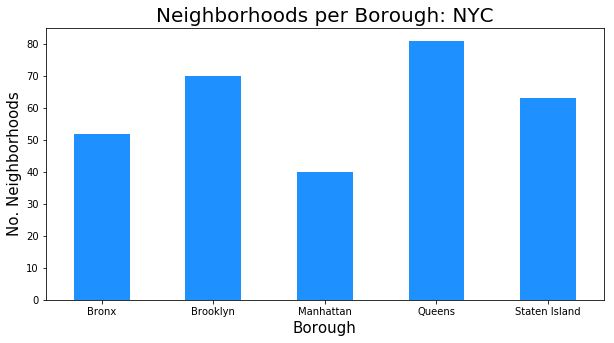

In [13]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [14]:
# queens has most neighborhoods
# prepare neighborhood list that contains italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    print(row)
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
['Bronx', '

( 68 / 306 ) Italian Resturants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Italian Resturants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Italian Resturants in Fort Greene, Brooklyn:3
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Italian Resturants in Park Slope, Brooklyn:1
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Italian Resturants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Italian Resturants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Italian Resturants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Italian Resturants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]


( 132 / 306 ) Italian Resturants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Italian Resturants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Italian Resturants in Howard Beach, Queens:3
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Italian Resturants in Corona, Queens:1
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Italian Resturants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Italian Resturants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Italian Resturants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Italian Resturants in Flushing, Queens:1
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Italian R

( 199 / 306 ) Italian Resturants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Italian Resturants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Italian Resturants in Rosebank, Staten Island:1
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Italian Resturants in West Brighton, Staten Island:2
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Italian Resturants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Italian Resturants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Italian Resturants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Italian Resturants in Port Richmond, 

( 260 / 306 ) Italian Resturants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Italian Resturants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Italian Resturants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Italian Resturants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Italian Resturants in Jamaica Hills, Queens:0
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Italian Resturants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Italian Resturants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Italian Resturants in Astoria Heights, Queens:1
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
(

In [41]:
italian_rest_ny.to_csv('italian_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [42]:
italian_rest_ny = pd.read_csv('italian_rest_ny_tocsv1.csv')
italian_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
230,230,Queens,Sunnyside Gardens,5699aa86498ef437b2fd7102,Zio Luigi
231,231,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's
232,232,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's
233,233,Staten Island,Prince's Bay,4c091311a1b32d7f5efb96f0,Certo's Gourmet Foods & Caterers
234,234,Staten Island,Lighthouse Hill,5079ccdce4b065f1dd8155ad,Casa verde


In [43]:
italian_rest_ny.shape

(235, 5)

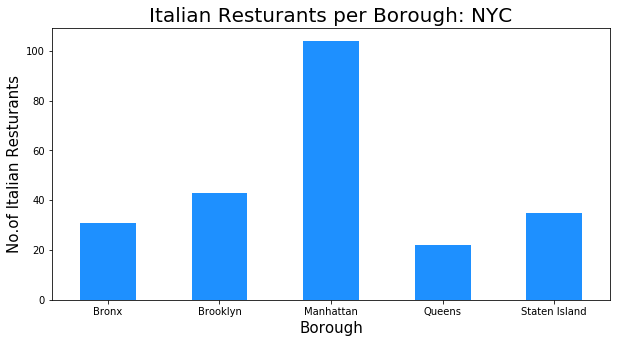

In [44]:
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Italian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

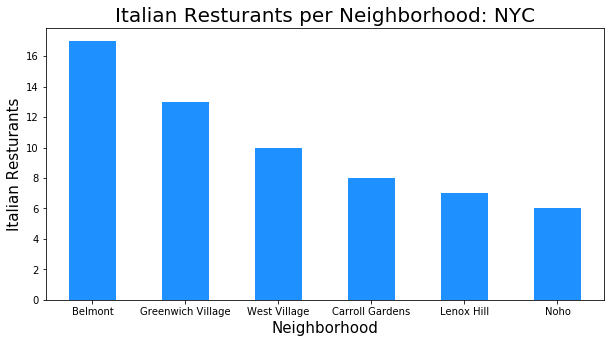

In [45]:
NOofNeigh = 6 # top number for graphing all the same past 6
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()


In [46]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

,Unnamed: 0,Borough,Neighborhood,ID,Name
7,7,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
8,8,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
9,9,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
10,10,Bronx,Belmont,4c9b9e7b9c663704b90463fd,Gerbasi Ristorante
11,11,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
12,12,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
13,13,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
14,14,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
15,15,Bronx,Belmont,4aa193d5f964a520124120e3,Mario's Restaurant & Catering
16,16,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant


In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()

In [ ]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project
italian_rest_stats_ny.shape
italian_rest_stats_ny.info()

In [ ]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')
italian_rest_stats_ny.info()

In [ ]:
italian_rest_stats_ny.describe()

In [ ]:
# Resturant with maximum Likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

In [ ]:
# Resturant with maximum Ratings
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

In [ ]:
# Resturant with maximum Tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

In [ ]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

In [ ]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

In [ ]:
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Italian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [ ]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

In [ ]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

In [ ]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [ ]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [ ]:

ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

In [ ]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')